In [13]:
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from numpy.random import randint, random
import scipy.stats
import math
import cv2
from scipy import ndimage
import imageio

from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from scipy import ndimage


In [14]:
# Convert MxNx3 image into Kx3 where K=MxN

# input fllename >> output 3d array
def read_img(filename, mode, size):
    if mode == 'RGB':
        img_3d = imageio.imread(filename, pilmode = 'RGB')
    elif mode == 'L':
        img_3d = imageio.imread(filename, pilmode = 'L')
    # Downsample the image
    small = cv2.resize(img_3d, (0, 0), fx = size[0], fy = size[1])
    # Blurring effect to denoise
    blur = cv2.blur(small, (4, 4))
    return blur


# input 3d array >> output 2d array
def flatten_img(img_3d, mode):
    if mode == 'RGB':
        x, y, z = img_3d.shape
        img_2d = img_3d.reshape(x*y, z)
        img_2d = np.array(img_2d, dtype = np.float)
    elif mode == 'L':
        x, y = img_3d.shape
        img_2d = img_3d.reshape(x*y, 1)
        img_2d = np.array(img_2d, dtype = np.float)
    return img_2d


# input 2d array >> output 3d array
def recover_img(img_2d, X, Y, mode = 'RGB', vis = False):
    #img_2d = cv2.resize(img_2d, (0, 0), fx=10, fy=10)
    if mode == 'RGB':
        img_2d = (img_2d * 255).astype(np.uint8)
        recover_img = img_2d.reshape(X, Y, 3)
    elif mode == 'L':
        recover_img = img_2d.reshape(X, Y)
    return recover_img


In [15]:
# input 2d array >> output estimated means, stds, pis
def kmeans_init(img, k):
    means, labels = kmeans2(img, k)
    try:
        means = np.array(means)
        cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
        ids = set(labels)
        pis = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    except Exception as ex:
        pass
    return means, cov, pis

def random_init(img, k):
    # For gray-scale
    if len(img.shape) == 1:
        means = randint(low = 0, high = 255, size = (k,1))
        cov = randint(low = 0, high = 500, size = k)
        pis = random(size = k)
    else:
        z = img.shape[1]
        means = randint(low = 0, high = 255, size = (k , z))
        cov = randint(low = 0, high = 500, size = (k, z, z))
        pis = random(size = k)
    return means, cov, pis

In [16]:
# E-Step: Update Parameters
def update_responsibility(img, means, cov, pis, k):
    responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)]).T
    norm = np.sum(responsibilities, axis = 1)
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities

# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis = 0) / responsibilities.shape[0]
    return pis

# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means

# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov

In [17]:
# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis = 1)
    return labels


def update_loglikelihood(img, means, cov, pis, k):
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum


def EM_cluster(img, k, random = False, error = 10e-4, iter_n = 9999):
    #  init setting
    cnt = 0
    likelihood_arr = []
    means_arr = []
    if not random:
        # Initialise E-Step by KMeans
        means, cov, pis = kmeans_init(img, k)
    else:
        means, cov, pis = random_init(img, k)
    likelihood = 0
    new_likelihood = 2
    means_arr.append(means)
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        start_dt = datetime.datetime.now()
        cnt += 1
        likelihood = new_likelihood
        # M-Step
        labels = update_labels(responsibilities)
        # E-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
        end_dt = datetime.datetime.now()
        diff = relativedelta(end_dt, start_dt)
        print("iter: %s, time interval: %s:%s:%s:%s" % (cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
        print("log-likelihood = {}".format(new_likelihood))
        # Store means stat
        means_arr.append(means)
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    return labels, means, cov, pis, likelihood_arr, means_arr

In [18]:
def get_pdf(y, means, cov, pis, k):
    pdf_arr = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(y, mean=means[j], cov=cov[j]) for j in range(k)])
    pdf = np.sum(pdf_arr)
    return pdf

In [19]:
FILENAME_LIST = ['/Users/MayraBerrones/Documents/VisualCode/minas/MIAS_Cancer/mdb001.png',
 '/Users/MayraBerrones/Documents/VisualCode/minas/MIAS_Cancer/mdb148.png',
 '/Users/MayraBerrones/Documents/VisualCode/minas/MIAS_Cancer/mdb005.png']

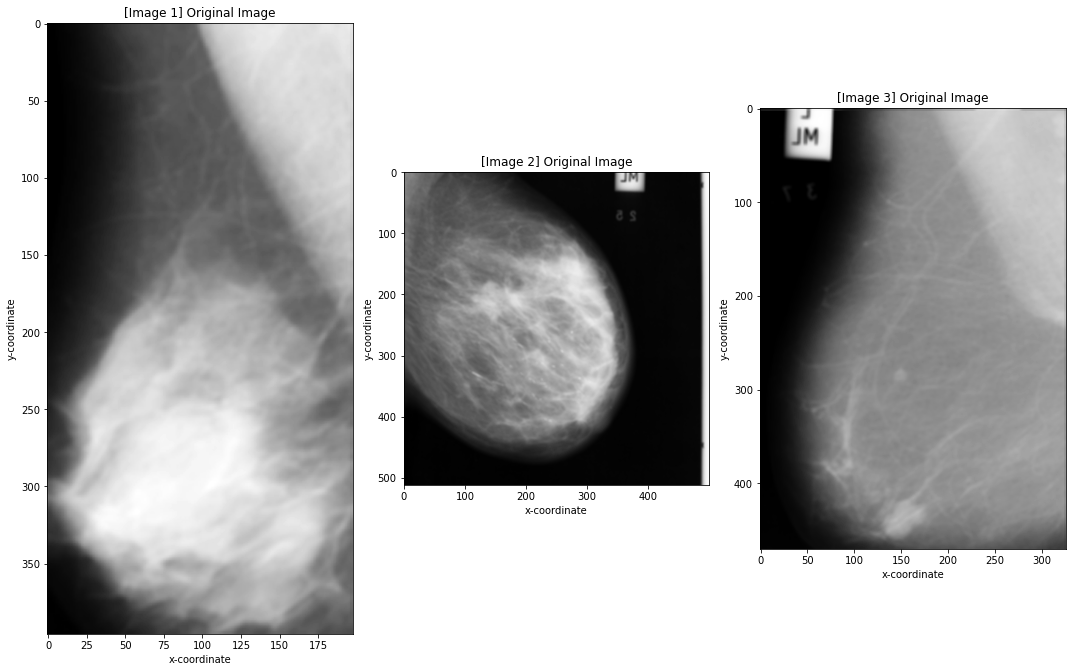

In [20]:
# Visualize demo images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
gray_img_list = []
dim_img_list = []
i = 1
for filename, ax in zip(FILENAME_LIST, ax_list):
    gray_img = read_img(filename = filename, mode = 'L', size = (0.5, 0.5))
    x, y = gray_img.shape
    # Store dimension for each image
    dim_img_list.append((x,y))
    # Store img 
    gray_img_list.append(gray_img)
    ax.imshow(gray_img, cmap = 'gray')
    ax.set_title('[Image {}] Original Image'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1

plt.tight_layout()
fig.savefig('orig_images.pdf')


In [21]:
img_list = [flatten_img(image, mode = 'L') for image in gray_img_list]

In [22]:
# Run and Store KMeans image
from sklearn import cluster
from scipy.cluster.vq import kmeans2
kmeans_img_list = []
for img, dim in zip(img_list, dim_img_list):
    k_means, k_labels = kmeans2(img, 2)
    kmeans_img = np.array([i[0] for i in k_means[k_labels]])
    kmeans_img = kmeans_img.reshape(dim[0], dim[1])
    kmeans_img_list.append(kmeans_img)

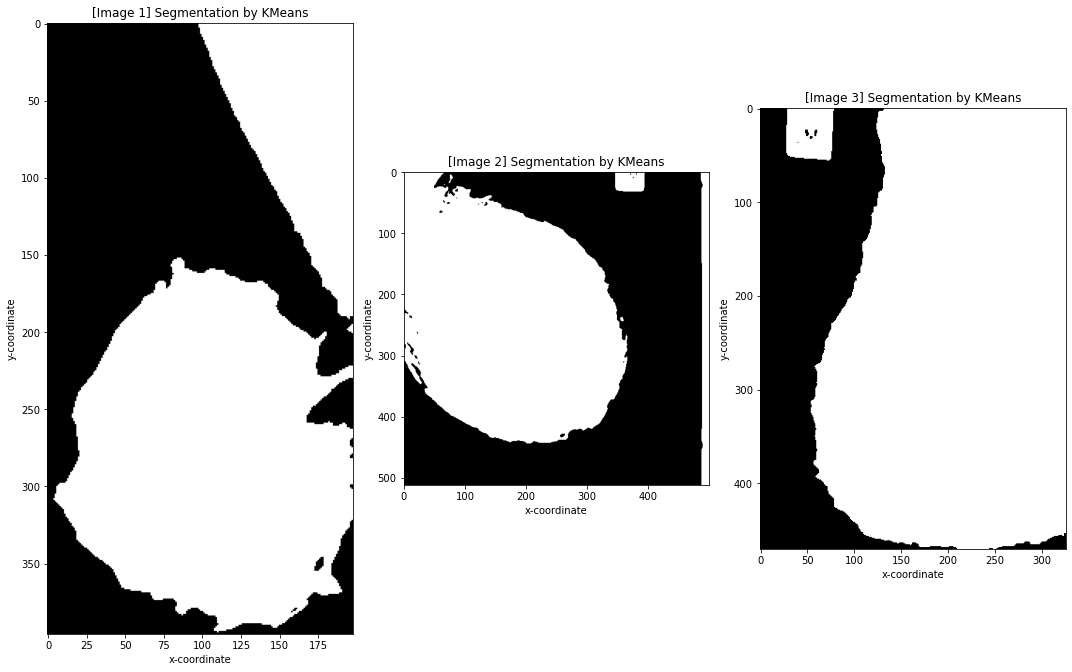

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
for kmeans_img, ax, dim in zip(kmeans_img_list, ax_list, dim_img_list):
    ax.imshow(kmeans_img, cmap = 'gray')
    ax.set_title('[Image {}] Segmentation by KMeans'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1
    
plt.tight_layout()
fig.savefig('kmeans_images.pdf')

In [91]:
# Init container
likelihood_arr_list = []
means_arr_list = []
cov_arr_list = []
pis_arr_list = []
em_img_list = []
means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 2, error = 0.001)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    likelihood_arr_list.append(likelihood_arr)
    means_arr_list.append(means_arr)
    cov_arr_list.append(cov)
    pis_arr_list.append(pis)
    em_img_list.append(recover_img)
    means_list.append(means)

iter: 1, time interval: 0:0:2:130480
log-likelihood = -426691.64341962
iter: 2, time interval: 0:0:2:156485
log-likelihood = -426510.1178330639
iter: 3, time interval: 0:0:2:162487
log-likelihood = -426377.95145191124
iter: 4, time interval: 0:0:2:228502
log-likelihood = -426272.63968190266
iter: 5, time interval: 0:0:2:197495
log-likelihood = -426188.18276752334
iter: 6, time interval: 0:0:2:96472
log-likelihood = -426120.3967799792
iter: 7, time interval: 0:0:2:171488
log-likelihood = -426065.8283494494
iter: 8, time interval: 0:0:2:211498
log-likelihood = -426021.69700658723
iter: 9, time interval: 0:0:2:143484
log-likelihood = -425985.8167176941
iter: 10, time interval: 0:0:2:175490
log-likelihood = -425956.4860632313
iter: 11, time interval: 0:0:2:142482
log-likelihood = -425932.3830276502
iter: 12, time interval: 0:0:2:230543
log-likelihood = -425912.47758158407
iter: 13, time interval: 0:0:2:160487
log-likelihood = -425895.96319540276
iter: 14, time interval: 0:0:2:119477
log-li

In [24]:
# Store density estimate (i.e pdf)
pdf_arr_list = []
for em_img, means, cov, pis in zip(em_img_list, means_list, cov_arr_list, pis_arr_list):
    pdf_arr = [get_pdf(i, means, cov, pis, 2) for i in np.linspace(0, 255, 256)]
    pdf_arr_list.append(pdf_arr)

NameError: name 'em_img_list' is not defined

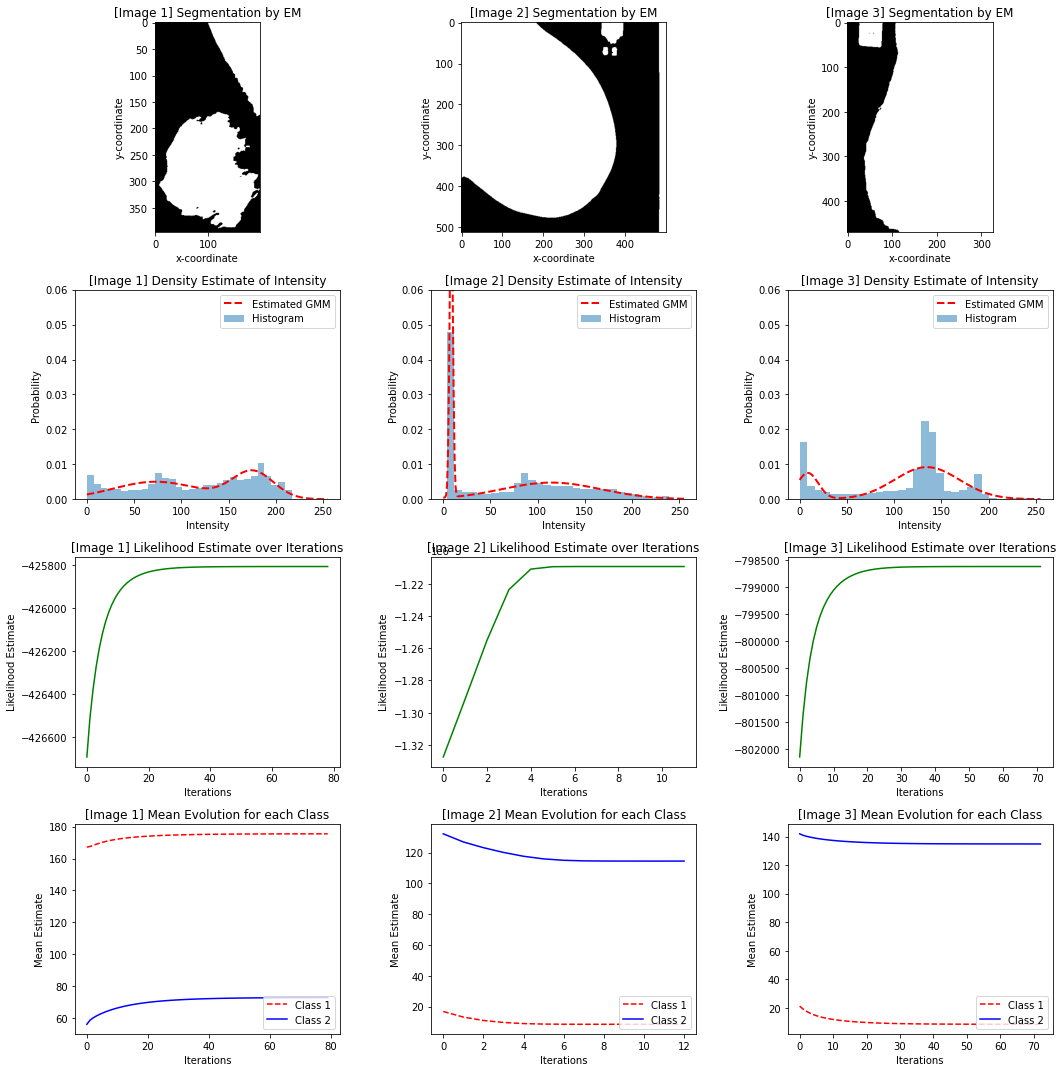

In [95]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for em_img, ax in zip(em_img_list, ax_list):
    ax.imshow(em_img, cmap = 'gray')
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1

# SECOND ROW: display density estimate
ax_list = [ax4, ax5, ax6]
i = 1
for img, pdf, ax in zip(img_list, pdf_arr_list, ax_list):
    ax.hist(img, bins = 30, density=True, stacked=True, alpha = 0.5, label='Histogram')
    ax.plot(pdf, 'r--', linewidth = 2, label = 'Estimated GMM')
    ax.set_title('[Image {}] Density Estimate of Intensity'.format(i))
    ax.legend()
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Intensity')
    ax.axes.set_ylabel('Probability')
    # Strink the y-axis
    ax.set_ylim(0, 0.06)    
    i += 1
    
# THIRD ROW: density estimate
ax_list = [ax7, ax8, ax9]
i = 1
for ll, ax in zip(likelihood_arr_list, ax_list):
    ax.plot(ll, 'g-')
    ax.set_title('[Image {}] Likelihood Estimate over Iterations'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Likelihood Estimate')
    i += 1

# FOURTH ROW: displays means evolution over iteration
ax_list = [ax10, ax11, ax12]
i = 1
for m, ax in zip(means_arr_list, ax_list):
    # The 2nd image has class label inversed
    if i == 2:
        # Remove inner index
        m1 = [i[1][0] for i in m]
        m2 = [i[0][0] for i in m]
    else:       
        m1 = [i[0][0] for i in m]
        m2 = [i[1][0] for i in m]
    ax.plot(m1, 'r--', label = 'Class 1')
    ax.plot(m2, 'b-', label = 'Class 2')
    ax.set_title('[Image {}] Mean Evolution for each Class'.format(i))
    ax.legend(loc = 4)
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Mean Estimate')
    i += 1

# Make a nice layout
plt.tight_layout()
plt.savefig("em_kmeans_init.pdf")

In [25]:
import numpy as np
import random
import cv2

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

image = read_img('/Users/MayraBerrones/Documents/VisualCode/minas/MIAS_Cancer/mdb001.png', mode = 'L', size = (0.6, 0.6)) # Only for grayscale image
noise_img = sp_noise(image,0.1)
x, y = noise_img.shape

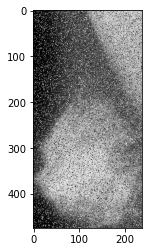

In [26]:
plt.imshow(noise_img, cmap = 'gray')

In [90]:
FILENAME1 = '/Users/MayraBerrones/Documents/VisualCode/Prueba/anomalia2.png' 
FILENAME2 = '/Users/MayraBerrones/Documents/VisualCode/Prueba/anomalia3.png'
X = 224
Y = 224
Z = 3